In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import os
import matplotlib.pyplot as plt
import ptitprince as pt
# sns.set(style="darkgrid")
#sns.set(style="whitegrid")
sns.set_style("white")
# sns.set(style="whitegrid",font_scale=2)


In [2]:
import matplotlib.font_manager as font_manager
from matplotlib import rc, rcParams

# Check if Arial is available
if 'Arial' in [f.name for f in font_manager.fontManager.ttflist]:
    # plt.rcParams['font.family'] = 'Arial'
    rc('axes', linewidth=0.5)
    rc('font', size=7)
    rcParams['font.family'] = 'Arial'
else:
    print("Arial font is not available. Using default.")

# Load datasets

In [3]:
adni_data_file = pd.read_csv('/data_1/skowshik/data/train_vld_test_split_updated/adni_merged.csv', usecols=['RID', 'amy_label', 'tau_label', 'fdg_label'])
adni_model_pred = pd.read_csv('/home/skowshik/publication_ADRD_repo/adrd_tool/model_predictions_stripped_MNI_swinunetr/adni_merged_swinunetr_prob.csv')
nacc_orig = pd.read_csv('/home/skowshik/data/new_nacc_unique_type_3.csv', usecols=['ID', 'cdr_CDRGLOB', 'AMYLPET', 'FDGAD', 'TAUPETAD', 'FDGFTLD', 'TPETFTLD', 'MRFTLD', 'DATSCAN'])
test = pd.read_csv('/data_1/skowshik/data/train_vld_test_split_updated/nacc_test_with_np_cli.csv')
nacc_prob = pd.read_csv('/home/skowshik/publication_ADRD_repo/adrd_tool/model_predictions_stripped_MNI_swinunetr/nacc_test_with_np_cli_swinunetr_prob.csv')
nacc_test = nacc_orig[nacc_orig['ID'].isin(test['ID'])]
nacc_merged = pd.merge(nacc_orig, nacc_prob, on=['ID', 'cdr_CDRGLOB'])

/tmp/ipykernel_1611389/2215117765.py:4: DtypeWarning: Columns (31,190,192,194,196,198,200,208,210,212,214,459) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv('/data_1/skowshik/data/train_vld_test_split_updated/nacc_test_with_np_cli.csv')


In [4]:
adni_data_file = pd.read_csv('/data_1/skowshik/data/train_vld_test_split_updated/adni_merged.csv')
adni_data_file.columns[adni_data_file.columns.str.contains('SMOK')]

Index(['his_SMOKYRS'], dtype='object')

In [5]:
adni_model_pred['RID'] = adni_model_pred['RID'].astype(int)
adni_data_file['RID'] = adni_data_file['RID'].astype(int)

In [6]:
# Get the amyloid values for the subjects in the adni data file
# adni_data_file['amy_label'] = np.NaN
# adni_data_file['tau_label'] = np.NaN
# adni_data_file['fdg_label'] = np.NaN
adni_data_file['DE_prob'] = np.NaN
adni_data_file['AD_prob'] = np.NaN

for i, row in adni_data_file.iterrows():
    # if row['RID'] in list(filtered_adni_amyloid_file['RID']):
        # adni_data_file.loc[adni_data_file['RID'] == row['RID'], 'amy_label'] = filtered_adni_amyloid_file[filtered_adni_amyloid_file['RID'] == row['RID']]['amy_label'].values[0]
        # adni_data_file.loc[adni_data_file['RID'] == row['RID'], 'tau_label'] = filtered_adni_amyloid_file[filtered_adni_amyloid_file['RID'] == row['RID']]['tau_label'].values[0]
        # adni_data_file.loc[adni_data_file['RID'] == row['RID'], 'fdg_label'] = filtered_adni_amyloid_file[filtered_adni_amyloid_file['RID'] == row['RID']]['fdg_label'].values[0]
    adni_data_file.loc[adni_data_file['RID'] == row['RID'], 'DE_prob'] = adni_model_pred[adni_model_pred['RID'] == row['RID']]['DE_prob'].values[0]
    adni_data_file.loc[adni_data_file['RID'] == row['RID'], 'AD_prob'] = adni_model_pred[adni_model_pred['RID'] == row['RID']]['AD_prob'].values[0]


# Merge cohorts

In [7]:
adni_data_file['Cohort'] = 'ADNI'
nacc_merged['Cohort'] = 'NACC'

In [8]:
adni_data_file.rename(columns={'amy_label': 'AMYLPET', 'tau_label': 'TAUPETAD', 'fdg_label': 'FDGAD'}, inplace=True)

In [9]:
df = pd.concat([nacc_merged, adni_data_file])

In [10]:
df.replace({'AMYLPET': {-4: np.nan, 8: np.nan}, 'TAUPETAD': {-4: np.nan, 8: np.nan}, 'FDGAD': {-4: np.nan, 8: np.nan}}, inplace=True)

In [11]:
# df.to_csv('/data_1/varuna/adrd_pet_data.csv', index=False)

# Stats Functions

In [12]:
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind, levene

def normality_test(df, X, Y):
    for g in df[X].unique():
        group = df[df[X] == g][Y]
        if len(group) > 3: # Shapiro-Wilk test is not suitable for very small samples
            try:
                shapiro_pvalue = stats.shapiro(group).pvalue
                print(f'Group {g}: Shapiro-Wilk Test, P-value = {shapiro_pvalue}, Normality Rejected: {shapiro_pvalue < 0.05}, Sample Size: {len(group)}')
                
                # For K-S test, consider standardizing or adjusting parameters
                ks_pvalue = stats.kstest(group, 'norm', args=(group.mean(), group.std())).pvalue
                print(f'Group {g}: K-S Test, P-value = {ks_pvalue}, Normality Rejected: {ks_pvalue < 0.05}')
                
            except Exception as e:
                print(f'Error testing group {g}: {e}')
                continue

def mannwhit(df, X, Y):
    
    # ‘two-sided’: the distributions are not equal, i.e. F(u) ≠ G(u) for at least one u.

    # ‘less’: the distribution underlying x is stochastically less than the distribution underlying y, i.e. F(u) > G(u) for all u.

    # ‘greater’: the distribution underlying x is stochastically greater than the distribution underlying y, i.e. F(u) < G(u) for all u.

    # print(f"Mann-Whitney U Test Statistic: {stat}, P-value: {p_value}")
    
    # Filter the DataFrame to create groups based on 'Positivity values
    group0 = df[df[X] == 0][Y]
    group1 = df[df[X] == 1][Y]

    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(group0, group1, alternative='less')
    print(f"Mann-Whitney U Test: Statistic = {stat}, P-value = {p_value}")

def indttest(df, X, Y):
    
    # Separate based on amyloid status
    group0 = df[df[X] == 0][Y]
    group1 = df[df[X] == 1][Y]

    # Check for equality of variances
    stat, p_value_levene = levene(group0, group1)
    print(f"Levene's Test for Equality of Variances: Statistic = {stat}, P-value = {p_value_levene}")
    if p_value_levene < 0.05:
        print("We cannot assume equality of variance - there's a statistically significant difference in the variances across the groups")
    else:
        print("We assume equality of variance")

    # Determine whether to assume equal variances based on Levene's test
    equal_var = True if p_value_levene > 0.05 else False # if levene is significant, we cannot assume equality of variance

    # Perform the independent samples t-test
    stat, p_value = ttest_ind(group0, group1, equal_var=equal_var, alternative='less')

    print(f"Independent Samples T-Test: Statistic = {stat}, P-value = {p_value}")


# Amyloid PET for AD

In [13]:
nacc_df = df[df['Cohort'] == 'NACC']
normality_test(nacc_df, 'AMYLPET', 'AD_prob')

Group 0.0: Shapiro-Wilk Test, P-value = 3.7531977840622956e-14, Normality Rejected: True, Sample Size: 204
Group 0.0: K-S Test, P-value = 6.291095415661682e-07, Normality Rejected: True
Group 1.0: Shapiro-Wilk Test, P-value = 1.784420332425323e-12, Normality Rejected: True, Sample Size: 236
Group 1.0: K-S Test, P-value = 0.00012888173356589316, Normality Rejected: True


In [14]:
adni_df = df[df['Cohort'] == 'ADNI']
adni_df.dropna(subset=['AMYLPET'], inplace=True)
normality_test(adni_df, 'AMYLPET', 'AD_prob')

Group 0.0: Shapiro-Wilk Test, P-value = 3.9103296412158337e-35, Normality Rejected: True, Sample Size: 653
Group 0.0: K-S Test, P-value = 3.754079349801824e-42, Normality Rejected: True
Group 1.0: Shapiro-Wilk Test, P-value = 2.603759699360818e-20, Normality Rejected: True, Sample Size: 455
Group 1.0: K-S Test, P-value = 3.892501142534947e-13, Normality Rejected: True


/tmp/ipykernel_1611389/3396335595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adni_df.dropna(subset=['AMYLPET'], inplace=True)


In [15]:
mannwhit(nacc_df, 'AMYLPET', 'AD_prob') # four stars

Mann-Whitney U Test: Statistic = 10303.5, P-value = 2.037431347784222e-25


In [16]:
adni_df.dropna(subset=['AD_prob', 'AMYLPET'], inplace= True)

/tmp/ipykernel_1611389/406664959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adni_df.dropna(subset=['AD_prob', 'AMYLPET'], inplace= True)


In [17]:
indttest(adni_df,'AMYLPET', 'AD_prob') # four stars

Levene's Test for Equality of Variances: Statistic = 173.86055493833913, P-value = 5.57986592245387e-37
We cannot assume equality of variance - there's a statistically significant difference in the variances across the groups
Independent Samples T-Test: Statistic = -12.060217522431328, P-value = 9.737768944464039e-31


In [18]:
# colorblind friendly
cb_palette = sns.color_palette("colorblind")
custom_pal = {0: cb_palette[0], 1: cb_palette[4]}
# custom_pal_colorblind = {0: "#E69F00", 1: "#56B4E9"}  # orange and blue
# set2_palette = sns.color_palette("Set3")
# custom_pal = {0: set2_palette[2], 1: set2_palette[3]}

In [19]:
# dx = "Cohort"; dy = "AD_prob"; dhue = "AMYLPET"; ort='v'; label_fontsize=15; ticks_fontsize=15; sigma=0.5

# f, ax = plt.subplots(figsize=(12, 5))

# # RainCloud plot
# ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=df, palette=custom_pal, bw=sigma, width_viol=.7,
#                   ax=ax, orient=ort, alpha=.65, dodge=True, cut = 2)

# # Rename the legend labels to 'Negative' and 'Positive'
# new_legend_labels = ['Negative', 'Positive']

# # get unique labels to avoid repetitions for each distribution
# handles, original_labels = ax.get_legend_handles_labels()

# # rename legend and reposition
# legend = ax.legend(handles, new_legend_labels, title="Amyloid PET",
#                    loc='upper left', bbox_to_anchor=(1, 1))

# # extend x axis so nothing gets cut off
# current_left, current_right = ax.get_xlim()
# ax.set_xlim(current_left - 0.06, current_right + 0.06)

# # move grid up
# # current_y_max = ax.get_ylim()[1]  # get the current maximum y value
# # y_pos = current_y_max * 1.05 
# # ax.set_ylim(ax.get_ylim()[0], y_pos * 1.1)  # move the grid up so annotation fits

# # add stats
# x_pos = [-0.05, 0.06]  # X positions where you want the annotation to span
# y_pos = df[dy].max() + 0.00005  # Y position, slightly above the highest data point or box plot

# ax.plot(x_pos, [y_pos, y_pos], color="black", lw=0.5)  # Draw the line between the points we're comparing
# ax.text(np.mean(x_pos), y_pos , '****', ha='center', va='bottom', color="black", fontsize=14)  # Add asterisk for significance

# x_pos = [0.95, 1.06]  # X positions where you want the annotation to span
# y_pos = df[dy].max() + 0.00005  # Y position, slightly above the highest data point or box plot

# ax.plot(x_pos, [y_pos, y_pos], color="black", lw=0.5)  # Draw the line between the points we're comparing
# ax.text(np.mean(x_pos), y_pos , '****', ha='center', va='bottom', color="black", fontsize=14)  # Add asterisk for significance


# # rename and resize labels
# ax.set_xlabel("Cohort", fontsize = label_fontsize)
# ax.set_ylabel("AD Probability", fontsize = label_fontsize)
# ax.set_xticklabels(['NACC', 'ADNI'], fontsize = ticks_fontsize)
# # plt.title("Model Predicted AD Probabilities by Amyloid Status", fontsize=16)
# plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title

# plt.subplots_adjust(right=0.75) 

# plt.show()


In [20]:
# Get the palette
cb_palette = sns.color_palette("colorblind")
custom_pal = {0: cb_palette[9], 1: cb_palette[4]}

# label_fontsize = 20
# ticks_fontsize = 20
# sticker_fontsize = 15

# Get legend

In [21]:
# def plot_biomarker(df, dx, dy, dhue, ort, trim, ylabel, sticker, save_path):

#     f, ax = plt.subplots(figsize=(4, 2.3))
#     # RainCloud plot
#     ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=df, palette=custom_pal, bw=0.2, width_viol=.7, width_box=0.2,
#                       ax=ax, orient=ort, alpha=.65, dodge=True, cut = trim, offset=0.15, point_size = 2)
    
#     # Legend setup...
#     handles, labels = ax.get_legend_handles_labels()
#     new_legend_labels = ['Neg.', 'Pos.']  # Adjusted labels if necessary
#     legend = ax.legend(handles, new_legend_labels, title="Biomarker Status",
#                        loc='upper left', bbox_to_anchor=(1, 1),
#                        fontsize=label_fontsize, title_fontsize=label_fontsize)
             
#     # extend x axis so nothing gets cut off
#     current_left, current_right = ax.get_xlim()
#     ax.set_xlim(current_left - 0.06, current_right + 0.06)

#     # add stats
#     x_pos = [-0.04, 0.04]  # X positions where we want the annotation to span
#     y_pos = df[dy].max() + 0.05  # Y position, slightly above the highest data point or box plot
#     ax.plot(x_pos, [y_pos, y_pos], color="#404040", lw=0.5)  # draw the line between the points we're comparing
#     ax.text(np.mean(x_pos), y_pos , '****', ha='center', va='bottom', color="#404040", fontsize=16)  # Add asterisk for significance
#     line_length = 0.01  # Length of the ticks
#     ax.plot([x_pos[0], x_pos[0]], [y_pos - line_length, y_pos + line_length], color="#404040", lw=0.5)
#     ax.plot([x_pos[1], x_pos[1]], [y_pos - line_length, y_pos + line_length], color="#404040", lw=0.5)

#     x_pos = [0.96, 1.04]  # X positions where you want the second cohort annotation to span
#     y_pos = df[dy].max() + 0.05  # Y position, slightly above the highest data point or box plot
#     ax.plot(x_pos, [y_pos, y_pos], color="#404040", lw=0.5)  # Draw the line between the points we're comparing
#     ax.text(np.mean(x_pos), y_pos , '****', ha='center', va='bottom', color="#404040", fontsize=16)  # Add asterisk for significance
#     line_length = 0.01  # Length of the ticks
#     ax.plot([x_pos[0], x_pos[0]], [y_pos - line_length, y_pos + line_length], color="#404040", lw=0.5)
#     ax.plot([x_pos[1], x_pos[1]], [y_pos - line_length, y_pos + line_length], color="#404040", lw=0.5)

#     # rename and resize labels
#     ax.set_xlabel("", fontsize = label_fontsize)
#     ax.set_ylabel(ylabel, fontsize = label_fontsize)
#     ax.set_xticklabels(['NACC', 'ADNI'], fontsize = ticks_fontsize)
#     ax.tick_params(axis='both', labelsize=ticks_fontsize)
#     # ax.legend().remove() # remove
#     ax.text(0.03, 0.95, sticker, fontsize=sticker_fontsize, ha="left", va="top",
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#404040", lw=0.5),
#     transform=ax.transAxes)

#     plt.subplots_adjust(right=0.75)
#     if save_path:
#         plt.savefig(save_path,dpi=300, bbox_inches='tight')
#     plt.show()
#     # ax.legend().remove() # remove


In [22]:
# plot_biomarker(df, "Cohort", "AD_prob", "AMYLPET", "v", 3, r"$P(AD)$",  r"A$\beta$ PET", "final_figs/biomarker_legend.svg")

# Modified source code

In [23]:
import ptitprince1 as pt
from matplotlib import font_manager
import matplotlib as mpl
font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
font_manager.findfont("Arial") 
# mpl.rc('axes', linewidth=0.5)
# mpl.rc('font', size=18)
# mpl.rcParams['font.family'] = 'Arial'
import matplotlib.collections as clt
# plt.rc('axes', linewidth=0.5)
# plt.rc('font', size=18)
# plt.rcParams['font.family'] = 'Arial'

In [24]:
# Get the palette
cb_palette = sns.color_palette("colorblind")
custom_pal = {0: cb_palette[9], 1: cb_palette[4]}

# global definitions
label_fontsize = 7
ticks_fontsize = 7
sticker_fontsize = 7
asterisk_fontsize = 7

# Cohort Plot Function

In [25]:
def plot_cohorts(df, dx, dy, dhue, ort, trim, ylabel, sticker, save_path):
    f, ax = plt.subplots(figsize=(4, 2.3))
    # RainCloud plot
    ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=df, palette=custom_pal, bw=0.2, width_viol=.7, width_box=0.2,
                      ax=ax, orient=ort, alpha=.65, dodge=True, cut = trim, offset=0.15, point_size = 1.2, jitter=0.1, linewidth=0.5)
                    
    # extend x axis so nothing gets cut off
    current_left, current_right = ax.get_xlim()
    ax.set_xlim(current_left - 0.2, current_right + 0.2)

    # add stats
    x_pos = [-0.04, 0.04]  # X positions where we want the annotation to span
    y_pos = df[dy].max() + 0.05  # Y position, slightly above the highest data point or box plot
    ax.plot(x_pos, [y_pos, y_pos], color="#404040", lw=0.5)  # draw the line between the points we're comparing
    ax.text(np.mean(x_pos), y_pos , '****', ha='center', va='bottom', color="#404040", fontname='Arial', fontsize=asterisk_fontsize)  # Add asterisk for significance
    line_length = 0.01  # Length of the ticks
    ax.plot([x_pos[0], x_pos[0]], [y_pos - line_length, y_pos + line_length], color="#404040", lw=0.5)
    ax.plot([x_pos[1], x_pos[1]], [y_pos - line_length, y_pos + line_length], color="#404040", lw=0.5)

    x_pos = [0.96, 1.04]  # X positions where you want the second cohort annotation to span
    y_pos = df[dy].max() + 0.05  # Y position, slightly above the highest data point or box plot
    ax.plot(x_pos, [y_pos, y_pos], color="#404040", lw=0.5)  # Draw the line between the points we're comparing
    ax.text(np.mean(x_pos), y_pos , '****', ha='center', va='bottom', color="#404040", fontname='Arial', fontsize=asterisk_fontsize)  # Add asterisk for significance
    line_length = 0.01  # Length of the ticks
    ax.plot([x_pos[0], x_pos[0]], [y_pos - line_length, y_pos + line_length], color="#404040", lw=0.5)
    ax.plot([x_pos[1], x_pos[1]], [y_pos - line_length, y_pos + line_length], color="#404040", lw=0.5)

    # rename and resize labels
    ax.set_xlabel("",  fontname='Arial', fontsize = label_fontsize)
    ax.set_ylabel(ylabel, fontname='Arial', fontsize = label_fontsize)
    ax.set_xticklabels(['NACC', 'ADNI'], fontname='Arial', fontsize = ticks_fontsize)
    ax.tick_params(axis='both', labelsize=ticks_fontsize)

    # rename legend and reposition
    ax.text(0.02, 0.97, sticker, fontname='Arial', fontsize=sticker_fontsize, ha="left", va="top",
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="#404040", lw=0.5),
    transform=ax.transAxes)
    ax.set_ylim(-0.2, 1.25)  # Set the limits of the y-axis
    ax.set_yticks(np.arange(0, 1.2, 0.2))  # Set y-ticks to range from 0 to 1 in increments of 0.2
    ax.legend().remove() # remove
    plt.subplots_adjust(right=0.75)
    if save_path:
        plt.savefig(save_path,dpi=300, bbox_inches='tight')
    plt.show()

hello


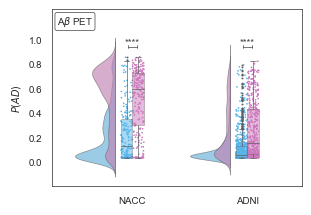

In [26]:
# plot_cohorts(df, "Cohort", "AD_prob", "AMYLPET", "v", 3, r"$P(AD)$",  r"A$\beta$ PET", "final_figs/amyloid_ad.pdf")
# plot_cohorts(df, "Cohort", "AD_prob", "AMYLPET", "v", 3, r"$P(AD)$",  r"A$\beta$ PET", "final_figs/png/amyloid_ad.png")
plot_cohorts(df, "Cohort", "AD_prob", "AMYLPET", "v", 3, r"$P(AD)$",  r"A$\beta$ PET", "final_figs/amyloid_ad.pdf")

# Tau PET for AD

In [27]:
normality_test(nacc_df, 'TAUPETAD', 'AD_prob')

Group 0.0: Shapiro-Wilk Test, P-value = 1.7616028773188664e-06, Normality Rejected: True, Sample Size: 81
Group 0.0: K-S Test, P-value = 0.05466521042957907, Normality Rejected: False
Group 1.0: Shapiro-Wilk Test, P-value = 0.0006015354079909111, Normality Rejected: True, Sample Size: 51
Group 1.0: K-S Test, P-value = 0.0904348605864369, Normality Rejected: False


In [28]:
mannwhit(nacc_df, 'TAUPETAD', 'AD_prob') # 4 stars

Mann-Whitney U Test: Statistic = 935.5, P-value = 6.480839175681842e-08


In [29]:
normality_test(adni_df, 'TAUPETAD', 'AD_prob')

Group 0.0: Shapiro-Wilk Test, P-value = 3.3908016850005255e-30, Normality Rejected: True, Sample Size: 373
Group 0.0: K-S Test, P-value = 4.09884884838795e-30, Normality Rejected: True
Group 1.0: Shapiro-Wilk Test, P-value = 3.186222970215916e-05, Normality Rejected: True, Sample Size: 102
Group 1.0: K-S Test, P-value = 0.053393904485872876, Normality Rejected: False


In [30]:
mannwhit(adni_df, 'TAUPETAD', 'AD_prob') # 4 stars

Mann-Whitney U Test: Statistic = 5857.5, P-value = 4.096324991880399e-27


hello


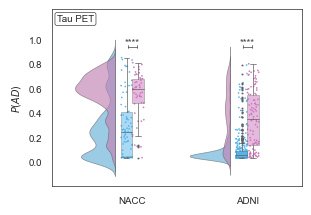

In [31]:
plot_cohorts(df, "Cohort", "AD_prob", "TAUPETAD", "v", 3, r"$P(AD)$", "Tau PET", "final_figs/tau_ad.pdf")
# plot_cohorts(df, "Cohort", "AD_prob", "TAUPETAD", "v", 3, r"$P(AD)$", "Tau PET", "final_figs/png/tau_ad.png")

# FDG PET for AD

In [32]:
normality_test(nacc_df, 'FDGAD', 'AD_prob')
normality_test(adni_df, 'FDGAD', 'AD_prob')

Group 0.0: Shapiro-Wilk Test, P-value = 4.4078117496312254e-05, Normality Rejected: True, Sample Size: 139
Group 0.0: K-S Test, P-value = 0.33583146519179785, Normality Rejected: False
Group 1.0: Shapiro-Wilk Test, P-value = 0.00010053869966041137, Normality Rejected: True, Sample Size: 122
Group 1.0: K-S Test, P-value = 0.18218481913609436, Normality Rejected: False
Group 0.0: Shapiro-Wilk Test, P-value = 2.512796176518376e-28, Normality Rejected: True, Sample Size: 595
Group 0.0: K-S Test, P-value = 1.682423731250591e-24, Normality Rejected: True
Group 1.0: Shapiro-Wilk Test, P-value = 8.640639958167783e-06, Normality Rejected: True, Sample Size: 165
Group 1.0: K-S Test, P-value = 0.04078589592111892, Normality Rejected: True


In [33]:
mannwhit(nacc_df, 'FDGAD', 'AD_prob') # 4 stars
mannwhit(adni_df, 'FDGAD', 'AD_prob') # 4 stars

Mann-Whitney U Test: Statistic = 3730.0, P-value = 3.000679444730613e-15
Mann-Whitney U Test: Statistic = 14924.0, P-value = 5.657162313403359e-43


hello


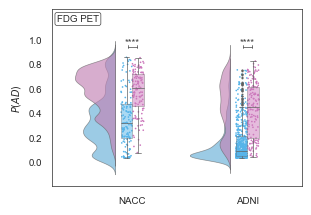

In [34]:
plot_cohorts(df, "Cohort", "AD_prob", "FDGAD", "v", 3, r"$P(AD)$", "FDG PET", "final_figs/fdg_ad.pdf")
# plot_cohorts(df, "Cohort", "AD_prob", "FDGAD", "v", 3, r"$P(AD)$", "FDG PET", "final_figs/png/fdg_ad.png")

# NACC Only

# Plot Function NACC

In [35]:
from statannotations.Annotator import Annotator

In [36]:
def plot_nacc(df, dx, dy, ort, trim, ylabel, stats_offset, sig, sticker, save_path):
    f, ax = plt.subplots(figsize=(4, 2.3))

    # RainCloud plot
    ax = pt.RainCloud(x=dx, y=dy, data=df, palette=custom_pal, bw=0.2, width_viol=.7, width_box=0.1,
                      ax=ax, orient=ort, alpha=.65, dodge=True, cut = trim, offset=0.15, point_size = 1.2, linewidth=0.5, jitter=0.06)

    # ax.legend().remove() # remove

    # extend x axis so nothing gets cut off
    current_left, current_right = ax.get_xlim()
    ax.set_xlim(current_left - 0.2, current_right + 0.2)

    # add stats
    x_pos = [0, 1.0]  # X positions where we want the annotation to span
    y_pos = df[dy].max() + stats_offset  # Y position, slightly above the highest data point or box plot
    line_length = 0.02  # Length of the ticks
    ax.plot(x_pos, [y_pos, y_pos], color="#404040", lw=0.5)  # draw the line between the points we're comparing
    ax.plot([x_pos[0], x_pos[0]], [y_pos - line_length, y_pos + line_length], color="#404040", lw=0.5)
    ax.plot([x_pos[1], x_pos[1]], [y_pos - line_length, y_pos + line_length], color="#404040", lw=0.5)

    ax.text(np.mean(x_pos), y_pos , sig, ha='center', va='bottom', color="#404040", fontsize=asterisk_fontsize)  # Add asterisk for significance
    # rename and resize labels
    ax.set_xlabel("", fontsize = label_fontsize)
    ax.set_ylabel(ylabel, fontsize = label_fontsize)
    ax.set_xticklabels(['', ''])
    ax.tick_params(axis='both', labelsize=ticks_fontsize)
    ax.text(0.02, 0.97, sticker, fontsize=sticker_fontsize, ha="left", va="top",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="#404040", lw=0.5),
        transform=ax.transAxes)
    # Set y-axis range and ticks
    ax.set_ylim(-0.2, 1.25)  # Set the limits of the y-axis
    ax.set_yticks(np.arange(0, 1.2, 0.2))  # Set y-ticks to range from 0 to 1 in increments of 0.2
    plt.subplots_adjust(right=0.75)
    if save_path:
        plt.savefig(save_path,dpi=300, bbox_inches='tight')

    plt.show()

# FTD 

In [37]:
nacc_df_ftd = nacc_df.dropna(subset=['FDGFTLD'])
nacc_df_ftd['FDGFTLD'].value_counts()
nacc_df_ftd.replace({-4: np.nan, 8: np.nan}, inplace = True)
nacc_df_ftd['FDGFTLD'].value_counts()

0.0    181
1.0     52
Name: FDGFTLD, dtype: int64

# FDG for FTD

In [38]:
normality_test(nacc_df_ftd, 'FDGFTLD', 'FTD_prob')

Group 0.0: Shapiro-Wilk Test, P-value = 0.011173172431045167, Normality Rejected: True, Sample Size: 181
Group 0.0: K-S Test, P-value = 0.7499167256802334, Normality Rejected: False
Group 1.0: Shapiro-Wilk Test, P-value = 3.0565436134384395e-05, Normality Rejected: True, Sample Size: 52
Group 1.0: K-S Test, P-value = 0.10262745581101507, Normality Rejected: False


In [39]:
mannwhit(nacc_df_ftd,'FDGFTLD', 'FTD_prob') # four stars

Mann-Whitney U Test: Statistic = 1599.5, P-value = 2.0813651640762862e-13


hello


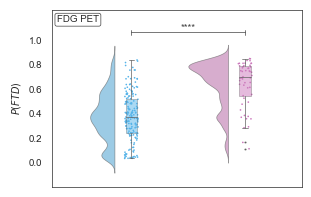

In [40]:
plot_nacc(nacc_df_ftd, "FDGFTLD", "FTD_prob", "v", 3, r"$P(FTD)$", 0.2, "****", "FDG PET", "final_figs/fdg_ftd.pdf")
# plot_nacc(nacc_df_ftd, "FDGFTLD", "FTD_prob", "v", 3, r"$P(FTD)$", 0.2, "****", "FDG PET", "final_figs/png/fdg_ftd.png")

# Tau PET Pattern for FTD

In [41]:
normality_test(nacc_df_ftd, 'TPETFTLD', 'FTD_prob')

Group 0.0: Shapiro-Wilk Test, P-value = 0.0006183716367575918, Normality Rejected: True, Sample Size: 123
Group 0.0: K-S Test, P-value = 0.3452995457209736, Normality Rejected: False
Group 1.0: Shapiro-Wilk Test, P-value = 0.36897134306585055, Normality Rejected: False, Sample Size: 6
Group 1.0: K-S Test, P-value = 0.8443108332331162, Normality Rejected: False


In [42]:
mannwhit(nacc_df_ftd,'TPETFTLD', 'FTD_prob')

Mann-Whitney U Test: Statistic = 257.5, P-value = 0.10722282728917254


hello


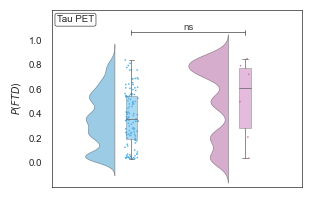

In [43]:
plot_nacc(nacc_df_ftd, "TPETFTLD", "FTD_prob", "v", 3, r"$P(FTD)$", 0.2, "ns", "Tau PET", "final_figs/tau_ftd.pdf")

# MR Evidence for FTD

In [44]:
normality_test(nacc_df_ftd, 'MRFTLD', 'FTD_prob')

Group 0.0: Shapiro-Wilk Test, P-value = 3.9557254880225463e-26, Normality Rejected: True, Sample Size: 1329
Group 0.0: K-S Test, P-value = 2.0336254062513043e-16, Normality Rejected: True
Group 1.0: Shapiro-Wilk Test, P-value = 7.266284932883183e-11, Normality Rejected: True, Sample Size: 165
Group 1.0: K-S Test, P-value = 0.00034858754147750143, Normality Rejected: True


In [45]:
mannwhit(nacc_df_ftd,'MRFTLD', 'FTD_prob')

Mann-Whitney U Test: Statistic = 30935.5, P-value = 1.5189860538115352e-51


hello


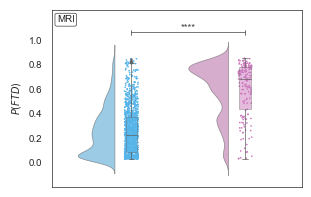

In [46]:
plot_nacc(nacc_df_ftd, "MRFTLD", "FTD_prob", "v", 3, r"$P(FTD)$", 0.2, "****", "MRI", "final_figs/MR_ftd.pdf")
# plot_nacc(nacc_df_ftd, "MRFTLD", "FTD_prob", "v", 3, r"$P(FTD)$", 0.2, "****", "MRI", "final_figs/png/MR_ftd.png")

# LBD

In [47]:
nacc_df_lbd = nacc_df.dropna(subset=['DATSCAN'])
nacc_df_lbd['DATSCAN'].value_counts()
nacc_df_lbd.replace({-4: np.nan, 8: np.nan}, inplace = True)
nacc_df_lbd['DATSCAN'].value_counts()

0.0    67
1.0    24
Name: DATSCAN, dtype: int64

In [48]:
normality_test(nacc_df_lbd, 'DATSCAN', 'LBD_prob')

Group 0.0: Shapiro-Wilk Test, P-value = 1.7938140929148961e-06, Normality Rejected: True, Sample Size: 67
Group 0.0: K-S Test, P-value = 0.0655358207671098, Normality Rejected: False
Group 1.0: Shapiro-Wilk Test, P-value = 0.05809334555407032, Normality Rejected: False, Sample Size: 24
Group 1.0: K-S Test, P-value = 0.8800257925738375, Normality Rejected: False


In [49]:
mannwhit(nacc_df_lbd,'DATSCAN', 'LBD_prob')

Mann-Whitney U Test: Statistic = 318.5, P-value = 6.258303041813397e-06


hello


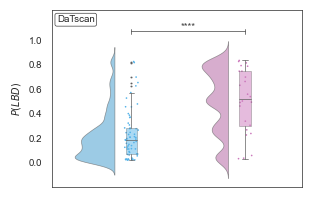

In [50]:
plot_nacc(nacc_df_lbd, "DATSCAN", "LBD_prob", "v", 3, r"$P(LBD)$", 0.09, "****", "DaTscan", "final_figs/DAT_lbd.pdf")
# plot_nacc(nacc_df_lbd, "DATSCAN", "LBD_prob", "v", 3, r"$P(LBD)$", 0.09, "****", "DaTscan", "final_figs/png/DAT_lbd.png")

# Generic plot for figure 1

In [51]:
# def plot_generic(df, dx, dy, ort, trim, ylabel, stats_offset, sig, sticker, save_path):
#     f, ax = plt.subplots(figsize=(5, 5))

#     # RainCloud plot
#     ax = pt.RainCloud(x=dx, y=dy, data=df, palette=custom_pal, bw=0.2, width_viol=.7, width_box=0.1,
#                       ax=ax, orient=ort, alpha=.65, dodge=True, cut = trim, offset=0.15, point_size = 2)
    
#     # extend x axis so nothing gets cut off
#     current_left, current_right = ax.get_xlim()
#     ax.set_xlim(current_left - 0.2, current_right + 0.2)

#     # add stats
#     x_pos = [0, 1.0]  # X positions where we want the annotation to span
#     y_pos = df[dy].max() + stats_offset  # Y position, slightly above the highest data point or box plot
#     line_length = 0.02  # Length of the ticks
#     ax.plot(x_pos, [y_pos, y_pos], color="#404040", lw=0.5)  # draw the line between the points we're comparing
#     ax.plot([x_pos[0], x_pos[0]], [y_pos - line_length, y_pos + line_length], color="#404040", lw=0.5)
#     ax.plot([x_pos[1], x_pos[1]], [y_pos - line_length, y_pos + line_length], color="#404040", lw=0.5)

#     ax.text(np.mean(x_pos), y_pos , sig, ha='center', va='bottom', color="#404040", fontsize=asterisk_fontsize)  # Add asterisk for significance
#     # rename and resize labels
#     ax.set_xlabel("", fontsize = label_fontsize)
#     ax.set_ylabel(ylabel, fontsize = label_fontsize)
#     ax.set_xticklabels(['', ''])
#     ax.tick_params(axis='both', labelsize=13)
#     # ax.text(0.038, 0.97, sticker, fontsize=12, ha="left", va="top",
#     #     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#404040", lw=0.5),
#     #     transform=ax.transAxes)
    
#     # Set y-axis range and ticks
#     ax.set_ylim(-0.2, 1.25)  # Set the limits of the y-axis
#     ax.set_yticks(np.arange(0, 1.2, 0.2))  # Set y-ticks to range from 0 to 1 in increments of 0.2
#     # plt.subplots_adjust(right=0.75)

#     if save_path:
#         plt.savefig(save_path,dpi=300, bbox_inches='tight')

#     plt.show()

In [52]:
# nacc_df_ad = nacc_df.dropna(subset=['TAUPETAD'])
# nacc_df_ad['TAUPETAD'].value_counts()
# # nacc_df_ad.replace({-4: np.nan, 8: np.nan}, inplace = True)
# # nacc_df_ad['TAUPETAD'].value_counts()

In [53]:
# plot_generic(nacc_df_ad, "TAUPETAD", "AD_prob", "v", 3, r"$P(DE)$", 0.15, "****", "Biomarker Status", 'final_figs/generic.svg')

In [54]:
# from statannotations.Annotator import Annotator

# f, ax = plt.subplots(figsize=(10, 5))

# # Generate the RainCloud plot
# ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=df, palette=custom_pal, bw=sigma, width_viol=.7,
#                   ax=ax, orient=ort, alpha=.65, dodge=True, move=.2)

# pairs = [(("NACC", 0), ("NACC", 1)), (("ADNI", 0), ("ADNI", 1))]  # Define the pairs you want to test and annotate

# # Initialize the Annotator with the ax object, data, pairs to compare, and the test to use
# annotator = Annotator(ax, pairs, data=df, x=dx, y=dy, hue=dhue, orient=ort)
# annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
# annotator.apply_and_annotate()


# # Adjust plot elements
# ax.set_xlabel("Cohort", fontsize=15)
# ax.set_ylabel("AD Probability", fontsize=15)
# plt.title("Model Predicted AD Probabilities by Amyloid Status", fontsize=16)

# plt.tight_layout()
# plt.show()
